# Preliminary consideration on energy cut (*re-processed QE=0.20*)

New consideration on energy cut only based on:
- Number of PE detected (*NPE*)
- Number of SiPM modules wt NPE>0 (*active slices*)

First, we will focus on single Ar39 vs Muons.
Then, we consider also other two *frequent* classes of 2, 3 Ar39 Pileups.

In [1]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import time
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})

In [2]:
def load_dataframe_from_files(dirin, fileprefix):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [3]:
# Load Ar39
init = time.time()
dirin = os.path.join("..", "Data", "OutputProcessing", "Ar39_08_18_2020", "Ar39_Snapshots")

fileprefix = "Snapshot1Ar39*"
df1ar39 = load_dataframe_from_files(dirin, fileprefix)

fileprefix = "Snapshot2Ar39*"
df2ar39 = load_dataframe_from_files(dirin, fileprefix)

fileprefix = "Snapshot3Ar39*"
df3ar39 = load_dataframe_from_files(dirin, fileprefix)

print("[Info] Loaded all 1,2,3 Ar39 Pileups in {:.2f} seconds".format(time.time() - init))

# Load Muons
init = time.time()
dirin = os.path.join("..", "Data", "OutputProcessing", "Muons_08_18_2020", "Muons_Snapshots")

fileprefix = "SnapshotMuons*"
dfmu = load_dataframe_from_files(dirin, fileprefix)
print("[Info] Loaded all Muons in {:.2f} seconds".format(time.time() - init))

[Info] Loading 100 files wt prefix:
Snapshot1Ar39*
...................................................................................................
[Info] Loading 100 files wt prefix:
Snapshot2Ar39*
...................................................................................................
[Info] Loading 100 files wt prefix:
Snapshot3Ar39*
...................................................................................................
[Info] Loaded all 1,2,3 Ar39 Pileups in 105.40 seconds
[Info] Loading 100 files wt prefix:
SnapshotMuons*
...................................................................................................
[Info] Loaded all Muons in 2.08 seconds


## Prepare features

In [4]:
def nr_active_slices(row):
    return np.nonzero(row.to_numpy())[0].shape[0]

In [5]:
n_inner_slices, n_outer_slices = 12, 20
df1ar39["NActiveSlices"] = df1ar39.iloc[:, 3:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df2ar39["NActiveSlices"] = df2ar39.iloc[:, 3:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df3ar39["NActiveSlices"] = df3ar39.iloc[:, 3:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
dfmu["NActiveSlices"] = dfmu.iloc[:, 3:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)

In [6]:
n_inner_slices, n_outer_slices = 12, 20
df1ar39["NActiveSlices_outer"] = df1ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df2ar39["NActiveSlices_outer"] = df2ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
df3ar39["NActiveSlices_outer"] = df3ar39.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
dfmu["NActiveSlices_outer"] = dfmu.iloc[:, 3+n_inner_slices:3+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)

# Various ROC, Mu vs 1Ar39
**Why consider only 1 Ar39?**

Given a decay rate of `3666 Hz` and a Detection Efficiency of `0.53035`, we expect a detection rate of `3666*.53035=1945 Hz`.
Looking at the Poisson distribution to compute the probability of multiple decay, we have:
- P[0 decay  | 10us] = 0.980737931
- P[1 decays | 10us] = 0.0190753528
- P[2 decays | 10us] = 0.0001855078
- P[>2 decays| 10us] = 0.000001208394
So the `P[1 decay|>1 decays]~.9903`, and to reduce the trigger rate we have to first cut off single decay.

To evaluate the various *simple* cut that can be performed on Number of PE detected (NPE) and Number of Active Slices (NAS), we plot several ROC curve, one for each feature on which we perform the cut.

In [7]:
# Tot NPE
thresholds = list(range(50, -1, -1))
tprs_tot_pe, fprs_tot_pe = [], []
# Tot NAS
tprs_tot_nas, fprs_tot_nas = [], []
# Out NAS
tprs_out_nas, fprs_out_nas = [], []
for threshold in thresholds:
    print(".", end="")
    # Tot NPE
    tp = len(dfmu[dfmu.pedetected>=threshold])
    fn = len(dfmu[dfmu.pedetected<threshold])
    tn = len(df1ar39[df1ar39.pedetected<threshold])
    fp = len(df1ar39[df1ar39.pedetected>=threshold])
    tprs_tot_pe.append(tp / (tp+fn))
    fprs_tot_pe.append(fp / (fp+tn))
    # Tot NAS
    tp = len(dfmu[dfmu.NActiveSlices>=threshold])
    fn = len(dfmu[dfmu.NActiveSlices<threshold])
    tn = len(df1ar39[df1ar39.NActiveSlices<threshold])
    fp = len(df1ar39[df1ar39.NActiveSlices>=threshold])
    tprs_tot_nas.append(tp / (tp+fn))
    fprs_tot_nas.append(fp / (fp+tn))
    # Out NAS
    tp = len(dfmu[dfmu.NActiveSlices_outer>=threshold])
    fn = len(dfmu[dfmu.NActiveSlices_outer<threshold])
    tn = len(df1ar39[df1ar39.NActiveSlices_outer<threshold])
    fp = len(df1ar39[df1ar39.NActiveSlices_outer>=threshold])
    tprs_out_nas.append(tp / (tp+fn))
    fprs_out_nas.append(fp / (fp+tn))

...................................................

Cut Out NAS: Threshold=1 => TPR=EFF=0.99677, FPR=0.92287
Cut Out NAS: Threshold=2 => TPR=EFF=0.91738, FPR=0.29852
Cut Out NAS: Threshold=3 => TPR=EFF=0.87361, FPR=0.08868
Cut Out NAS: Threshold=4 => TPR=EFF=0.84078, FPR=0.02295
Cut Out NAS: Threshold=5 => TPR=EFF=0.81232, FPR=0.00617


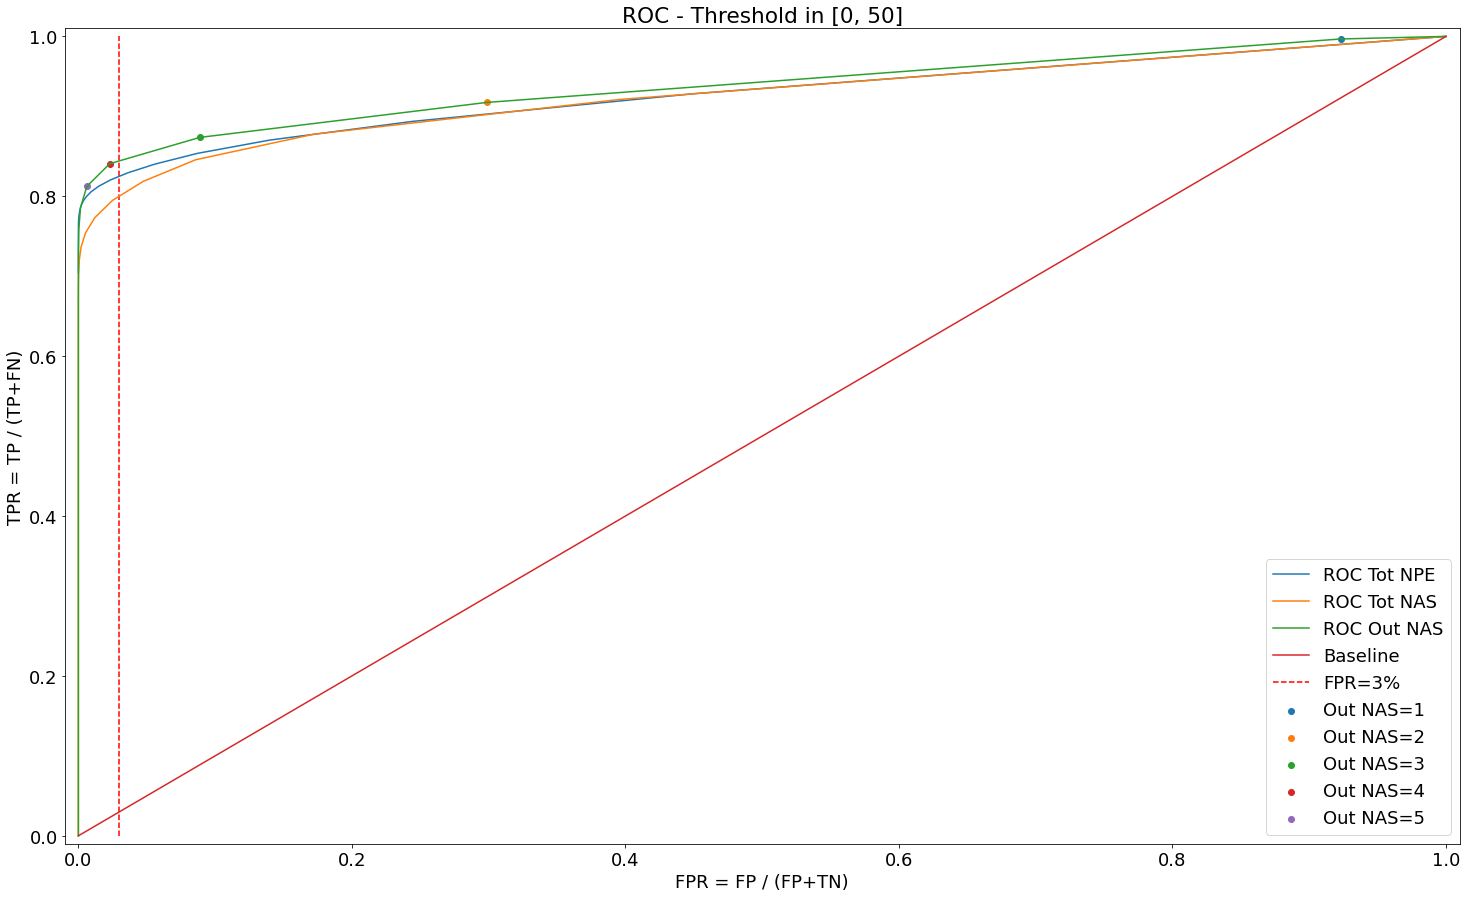

In [15]:
plt.plot(fprs_tot_pe, tprs_tot_pe, label="ROC Tot NPE")
plt.plot(fprs_tot_nas, tprs_tot_nas, label="ROC Tot NAS")
plt.plot(fprs_out_nas, tprs_out_nas, label="ROC Out NAS")
plt.plot(np.arange(50)/49, np.arange(50)/49, label="Baseline")

plt.vlines(0.03, ymin=0, ymax=1, label="FPR=3%", color='r', linestyles='dashed')

highlight_thresholds = [1, 2, 3, 4, 5]
for threshold in highlight_thresholds:
    id_threshold = thresholds.index(threshold)
    plt.scatter(fprs_out_nas[id_threshold], tprs_out_nas[id_threshold], label="Out NAS={}".format(threshold))
    print("Cut Out NAS: Threshold={} => TPR=EFF={:.5f}, FPR={:.5f}".format(threshold, tprs_out_nas[id_threshold], fprs_out_nas[id_threshold]))
plt.xlabel("FPR = FP / (FP+TN)")
plt.ylabel("TPR = TP / (TP+FN)")
plt.title("ROC - Threshold in [0, 50]")
plt.legend()
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.show()

# Second curve: ROC mu vs 2 Ar39s

In [16]:
# Tot NPE
thresholds = list(range(50, -1, -1))
tprs_tot_pe, fprs_tot_pe = [], []
# Tot NAS
tprs_tot_nas, fprs_tot_nas = [], []
# Out NAS
tprs_out_nas, fprs_out_nas = [], []
for threshold in thresholds:
    print(".", end="")
    # Tot NPE
    tp = len(dfmu[dfmu.pedetected>=threshold])
    fn = len(dfmu[dfmu.pedetected<threshold])
    tn = len(df2ar39[df2ar39.pedetected<threshold])
    fp = len(df2ar39[df2ar39.pedetected>=threshold])
    tprs_tot_pe.append(tp / (tp+fn))
    fprs_tot_pe.append(fp / (fp+tn))
    # Tot NAS
    tp = len(dfmu[dfmu.NActiveSlices>=threshold])
    fn = len(dfmu[dfmu.NActiveSlices<threshold])
    tn = len(df2ar39[df2ar39.NActiveSlices<threshold])
    fp = len(df2ar39[df2ar39.NActiveSlices>=threshold])
    tprs_tot_nas.append(tp / (tp+fn))
    fprs_tot_nas.append(fp / (fp+tn))
    # Out NAS
    tp = len(dfmu[dfmu.NActiveSlices_outer>=threshold])
    fn = len(dfmu[dfmu.NActiveSlices_outer<threshold])
    tn = len(df2ar39[df2ar39.NActiveSlices_outer<threshold])
    fp = len(df2ar39[df2ar39.NActiveSlices_outer>=threshold])
    tprs_out_nas.append(tp / (tp+fn))
    fprs_out_nas.append(fp / (fp+tn))

...................................................

Cut Out NAS: Threshold=1 => TPR=EFF=0.99677, FPR=0.99408
Cut Out NAS: Threshold=2 => TPR=EFF=0.91738, FPR=0.87823
Cut Out NAS: Threshold=3 => TPR=EFF=0.87361, FPR=0.44871
Cut Out NAS: Threshold=4 => TPR=EFF=0.84078, FPR=0.18191
Cut Out NAS: Threshold=5 => TPR=EFF=0.81232, FPR=0.06244


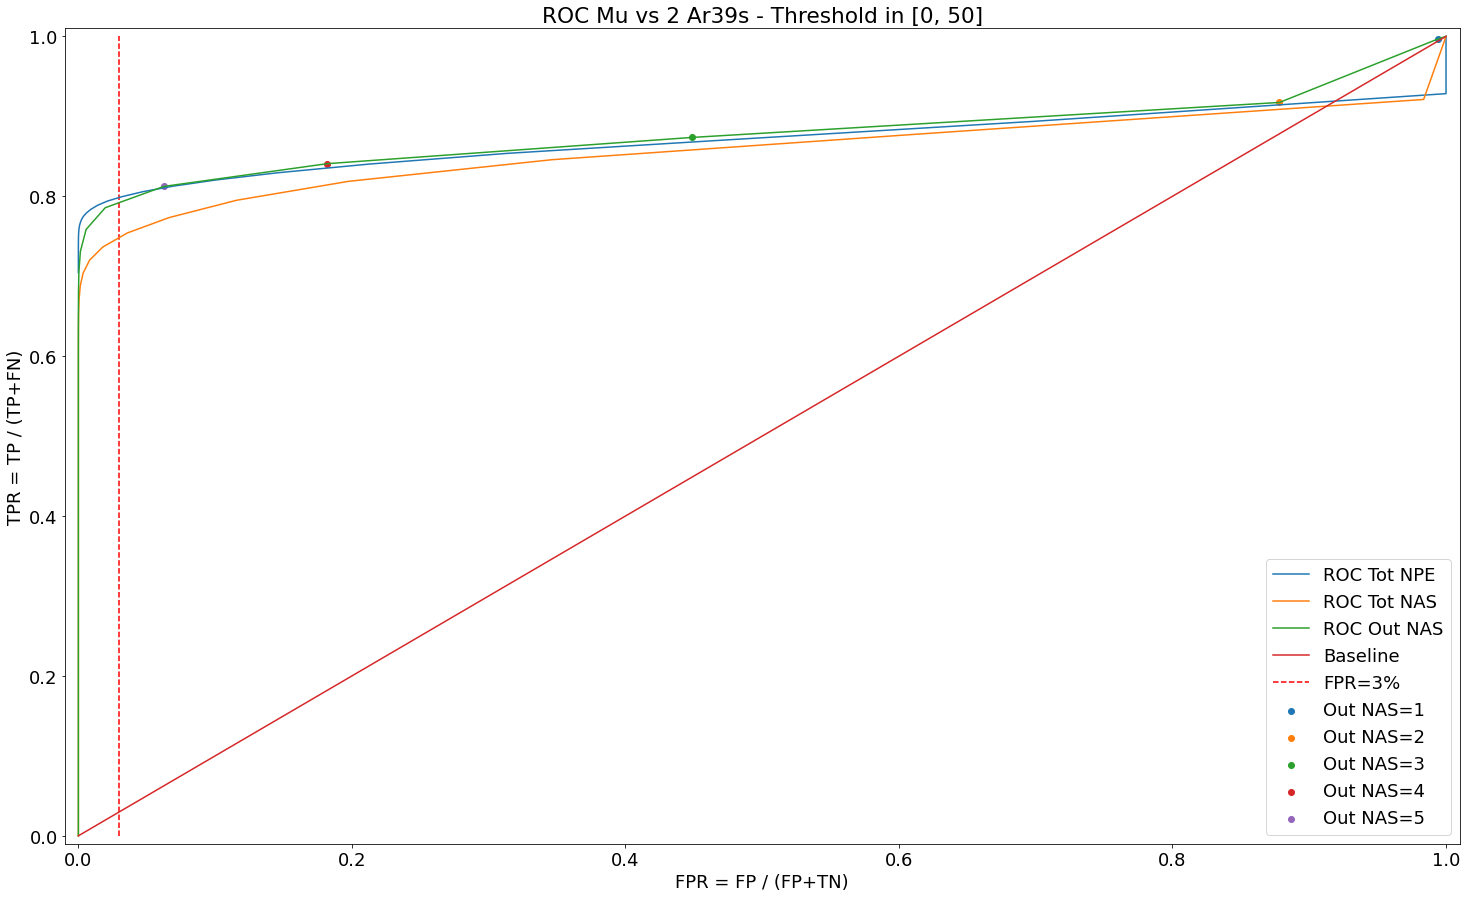

In [17]:
plt.plot(fprs_tot_pe, tprs_tot_pe, label="ROC Tot NPE")
plt.plot(fprs_tot_nas, tprs_tot_nas, label="ROC Tot NAS")
plt.plot(fprs_out_nas, tprs_out_nas, label="ROC Out NAS")
plt.plot(np.arange(50)/49, np.arange(50)/49, label="Baseline")

plt.vlines(0.03, ymin=0, ymax=1, label="FPR=3%", color='r', linestyles='dashed')

highlight_thresholds = [1, 2, 3, 4, 5]
for threshold in highlight_thresholds:
    id_threshold = thresholds.index(threshold)
    plt.scatter(fprs_out_nas[id_threshold], tprs_out_nas[id_threshold], label="Out NAS={}".format(threshold))
    print("Cut Out NAS: Threshold={} => TPR=EFF={:.5f}, FPR={:.5f}".format(threshold, tprs_out_nas[id_threshold], fprs_out_nas[id_threshold]))
plt.xlabel("FPR = FP / (FP+TN)")
plt.ylabel("TPR = TP / (TP+FN)")
plt.title("ROC Mu vs 2 Ar39s - Threshold in [0, 50]")
plt.legend()
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.show()

# Third curve: ROC mu vs 3 Ar39

In [18]:
# Tot NPE
thresholds = list(range(50, -1, -1))
tprs_tot_pe, fprs_tot_pe = [], []
# Tot NAS
tprs_tot_nas, fprs_tot_nas = [], []
# Out NAS
tprs_out_nas, fprs_out_nas = [], []
for threshold in thresholds:
    print(".", end="")
    # Tot NPE
    tp = len(dfmu[dfmu.pedetected>=threshold])
    fn = len(dfmu[dfmu.pedetected<threshold])
    tn = len(df3ar39[df3ar39.pedetected<threshold])
    fp = len(df3ar39[df3ar39.pedetected>=threshold])
    tprs_tot_pe.append(tp / (tp+fn))
    fprs_tot_pe.append(fp / (fp+tn))
    # Tot NAS
    tp = len(dfmu[dfmu.NActiveSlices>=threshold])
    fn = len(dfmu[dfmu.NActiveSlices<threshold])
    tn = len(df3ar39[df3ar39.NActiveSlices<threshold])
    fp = len(df3ar39[df3ar39.NActiveSlices>=threshold])
    tprs_tot_nas.append(tp / (tp+fn))
    fprs_tot_nas.append(fp / (fp+tn))
    # Out NAS
    tp = len(dfmu[dfmu.NActiveSlices_outer>=threshold])
    fn = len(dfmu[dfmu.NActiveSlices_outer<threshold])
    tn = len(df3ar39[df3ar39.NActiveSlices_outer<threshold])
    fp = len(df3ar39[df3ar39.NActiveSlices_outer>=threshold])
    tprs_out_nas.append(tp / (tp+fn))
    fprs_out_nas.append(fp / (fp+tn))

...................................................

Cut Out NAS: Threshold=1 => TPR=EFF=0.99677, FPR=0.99954
Cut Out NAS: Threshold=2 => TPR=EFF=0.91738, FPR=0.98329
Cut Out NAS: Threshold=3 => TPR=EFF=0.87361, FPR=0.85027
Cut Out NAS: Threshold=4 => TPR=EFF=0.84078, FPR=0.52075
Cut Out NAS: Threshold=5 => TPR=EFF=0.81232, FPR=0.25137


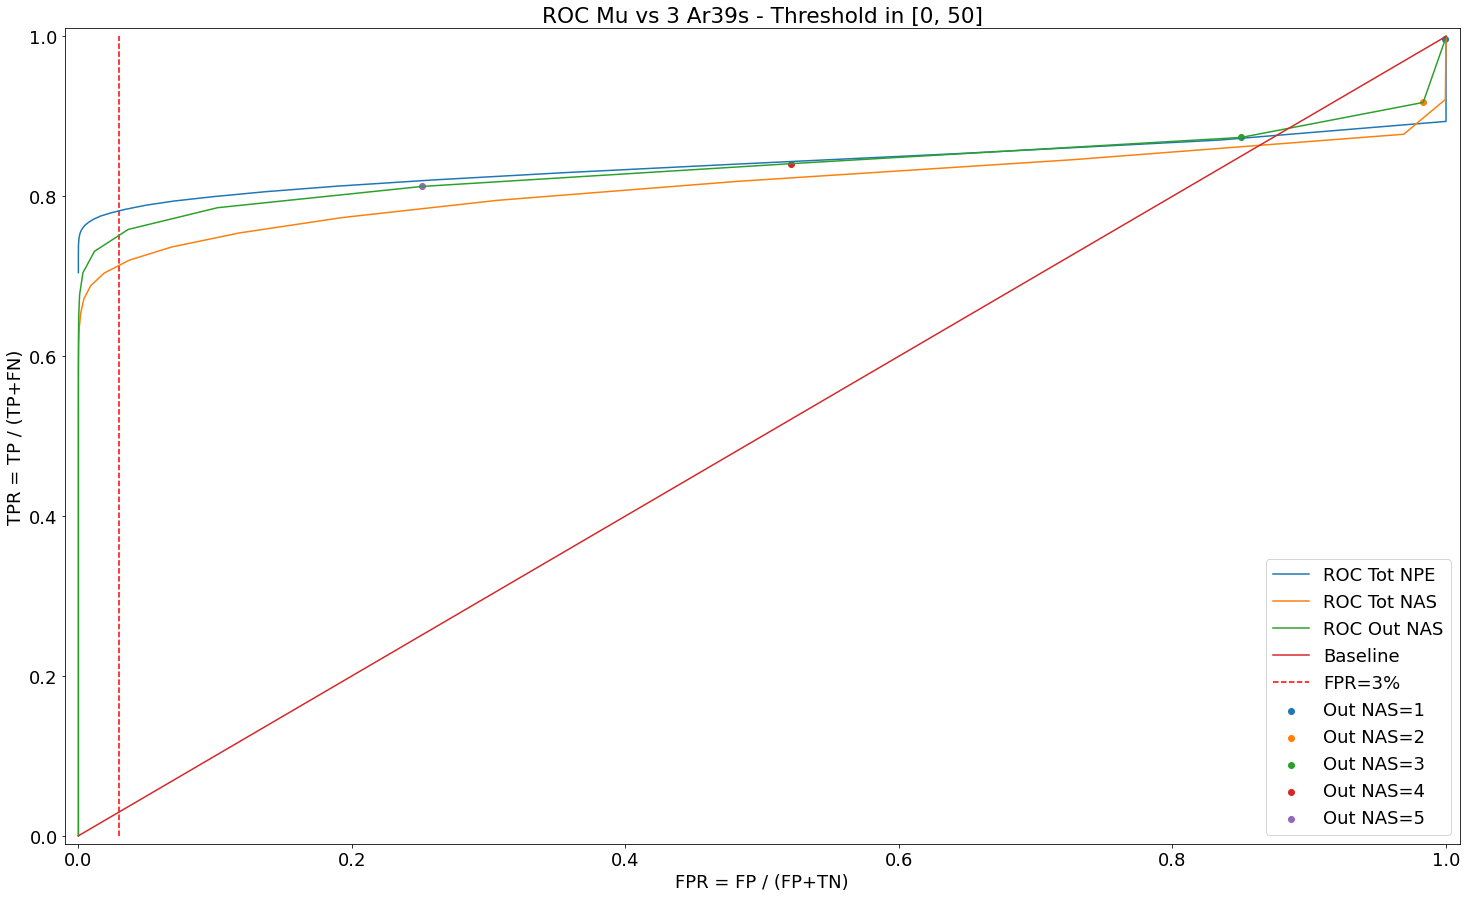

In [19]:
plt.plot(fprs_tot_pe, tprs_tot_pe, label="ROC Tot NPE")
plt.plot(fprs_tot_nas, tprs_tot_nas, label="ROC Tot NAS")
plt.plot(fprs_out_nas, tprs_out_nas, label="ROC Out NAS")
plt.plot(np.arange(50)/49, np.arange(50)/49, label="Baseline")

plt.vlines(0.03, ymin=0, ymax=1, label="FPR=3%", color='r', linestyles='dashed')

highlight_thresholds = [1, 2, 3, 4, 5]
for threshold in highlight_thresholds:
    id_threshold = thresholds.index(threshold)
    plt.scatter(fprs_out_nas[id_threshold], tprs_out_nas[id_threshold], label="Out NAS={}".format(threshold))
    print("Cut Out NAS: Threshold={} => TPR=EFF={:.5f}, FPR={:.5f}".format(threshold, tprs_out_nas[id_threshold], fprs_out_nas[id_threshold]))
plt.xlabel("FPR = FP / (FP+TN)")
plt.ylabel("TPR = TP / (TP+FN)")
plt.title("ROC Mu vs 3 Ar39s - Threshold in [0, 50]")
plt.legend()
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.show()

In [55]:
prel_cut_nas = 4
tot=len(dfmu[dfmu.NActiveSlices_outer>=prel_cut_nas])
print("[Info] Considering {} Muons wt >= {} Outer Active Slices".format(tot, prel_cut_nas))
# parameters
w=.75
test_perc = .10
test = round(tot * test_perc)
# compute ar39 dataset size
print("[Muons Dataset]")
print("\tInstances Test Muons: {}".format(test))
print("\tInstances Training Muons: {}".format(tot-test))

print("[Ar39 Dataset]")
print("\tInstances Test Ar39: all the rest")
for i in range(3):
    current = (tot-test)*w
    tot -= (tot-test)*w
    print("\tInstances Training {} Ar39: {}".format(i+1, round(current)))
print("\tInstances Training {} Ar39: {}".format(4, round(tot-test)))

[Info] Considering 132050 Muons wt >= 4 Outer Active Slices
[Muons Dataset]
	Instances Test Muons: 13205
	Instances Training Muons: 118845
[Ar39 Dataset]
	Instances Test Ar39: all the rest
	Instances Training 1 Ar39: 89134
	Instances Training 2 Ar39: 22283
	Instances Training 3 Ar39: 5571
	Instances Training 4 Ar39: 1857


In [81]:
# starting rate vs goal rate
ar39_weights = np.array([.990807, .009631, .000062])
ar39_fprs = np.array([.02295, .18191, .52075])
mu_tpr = .84078

print("[Info] Starting TPR: {:.5f}".format(mu_tpr))
print("[Info] Starting FPR: {:.5f}".format((ar39_weights * ar39_fprs).sum()))
print("[Info] Starting Trigger Rate: {:.0f}".format((ar39_weights * ar39_fprs).sum() * 1945))

print("The goal is to reduce the Trigger Rate <1 and keep TPR>.80")
print("[Info] Target TPR: {:.5f}".format(.80))
print("[Info] Target FPR: {:.5f}".format((ar39_weights * ar39_fprs).sum() / ((ar39_weights * ar39_fprs).sum() * 1945)))

[Info] Starting TPR: 0.84078
[Info] Starting FPR: 0.02452
[Info] Starting Trigger Rate: 48
The goal is to reduce the Trigger Rate <1 and keep TPR>.80
[Info] Target TPR: 0.80000
[Info] Target FPR: 0.00051
